In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import all necessary libraries
import time
import copy
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [ ]:
# Load the MFCCs data
X_train = np.load('/content/drive/MyDrive/music_genre_data_di/train/pyaudioanalysis/X.npy')
y_train = np.load('/content/drive/MyDrive/music_genre_data_di/train/pyaudioanalysis/labels.npy')

X_val = np.load('/content/drive/MyDrive/music_genre_data_di/val/pyaudioanalysis/X.npy')
y_val = np.load('/content/drive/MyDrive/music_genre_data_di/val/pyaudioanalysis/labels.npy')

X_test = np.load('/content/drive/MyDrive/music_genre_data_di/test/pyaudioanalysis/X.npy')
y_test = np.load('/content/drive/MyDrive/music_genre_data_di/test/pyaudioanalysis/labels.npy')

# Find the unique classes and replace them with numbers
class_names = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
label_mapping = {name: i for i, name in enumerate(class_names)}

y_train_int = np.array([label_mapping[label] for label in y_train])
y_val_int = np.array([label_mapping[label] for label in y_val])
y_test_int = np.array([label_mapping[label] for label in y_test])

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_int, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_int, dtype=torch.long)

# Create the dataloaders
batch_size = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FullyConnectedNet(nn.Module):
  def __init__(self, input_dim=26, hidden_dim1=128, hidden_dim2=32, output_dim=4):
    super(FullyConnectedNet, self).__init__()

    # 1st layer
    self.layer1 = nn.Linear(input_dim, hidden_dim1)
    # 2nd layer
    self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
    # 3rd layer
    self.layer3 = nn.Linear(hidden_dim2, output_dim)

  # Order they are performed
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return x

In [ ]:
def train_model(epochs, optimizer, dataloader, loss_function, model, device):
  # Set model to training mode
  model.train()

  # Move model to specified device(CPU or GPU)
  model.to(device)
  start_time = time.time()

  for epoch in range(epochs):
    epoch_loss = 0.0
    # Loop over the dataloader to get batches of data
    for batch_ids, (inputs, labels) in enumerate(dataloader):
      # Move the the input data and labels to the specified device
      inputs, labels = inputs.to(device), labels.to(device)

      # Clear the gradients from the previous iteration
      optimizer.zero_grad()

      # Feed the inputs to the model to get the outputs
      outputs = model(inputs)

      # Calculate the loss by comparing the model's outputs with the true labels
      loss = loss_function(outputs, labels)

      loss.backward()

      # Update model parameters
      optimizer.step()

      epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

  end_time = time.time()
  training_time = end_time - start_time
  print(f"\nTraining was complete in  {training_time:.2f} seconds.")

  return model

In [ ]:
def evaluate_model(dataloader, model, loss_function, device):
  # Set model to evaluation mode
  model.eval()

  # Move model to specified device(CPU or GPU)
  model.to(device)

  total_loss = 0.0
  predictions = []
  true_labels = []

  with torch.no_grad():
    # Iterate over each batch of data from the dataloader
    for inputs, labels in dataloader:
      # Move the the input data and labels to the specified device
      inputs, labels = inputs.to(device), labels.to(device)

      # Feed the inputs to the model to get the outputs
      outputs = model(inputs)

      # Calculate the loss for the current batch
      loss = loss_function(outputs, labels)
      total_loss += loss.item()

      # Get the predicted class for each input in the batch
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(predicted.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

  # Calculate all necessary metrics
  avg_loss = total_loss / len(dataloader)
  f1_macro = f1_score(true_labels, predictions, average='macro')
  accuracy = accuracy_score(true_labels, predictions)
  conf_matrix = confusion_matrix(true_labels, predictions)

  return avg_loss, f1_macro, accuracy, conf_matrix

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30

model = FullyConnectedNet()

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

device = "cpu"

# Train the network
print("Starting training...")
trained_model = train_model(epochs, optimizer, train_dataloader, loss_function, model, device)

# Evaluate the network
print("\nEvaluating trained model on the test set...")
test_loss, test_f1, test_accuracy, test_conf_matrix = evaluate_model(test_dataloader, trained_model, loss_function, device)

print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro-averaged): {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:\n", test_conf_matrix)

Starting training...
Epoch [1/30], Loss: 1.3911
Epoch [2/30], Loss: 1.3626
Epoch [3/30], Loss: 1.3409
Epoch [4/30], Loss: 1.3204
Epoch [5/30], Loss: 1.2964
Epoch [6/30], Loss: 1.2723
Epoch [7/30], Loss: 1.2398
Epoch [8/30], Loss: 1.2163
Epoch [9/30], Loss: 1.1885
Epoch [10/30], Loss: 1.1626
Epoch [11/30], Loss: 1.1363
Epoch [12/30], Loss: 1.1149
Epoch [13/30], Loss: 1.0898
Epoch [14/30], Loss: 1.0725
Epoch [15/30], Loss: 1.0545
Epoch [16/30], Loss: 1.0397
Epoch [17/30], Loss: 1.0226
Epoch [18/30], Loss: 1.0084
Epoch [19/30], Loss: 0.9981
Epoch [20/30], Loss: 0.9942
Epoch [21/30], Loss: 0.9830
Epoch [22/30], Loss: 0.9742
Epoch [23/30], Loss: 0.9677
Epoch [24/30], Loss: 0.9611
Epoch [25/30], Loss: 0.9565
Epoch [26/30], Loss: 0.9600
Epoch [27/30], Loss: 0.9415
Epoch [28/30], Loss: 0.9460
Epoch [29/30], Loss: 0.9431
Epoch [30/30], Loss: 0.9438

Training was complete in  5.17 seconds.

Evaluating trained model on the test set...
Loss: 0.9565
F1 (macro-averaged): 0.5725
Accuracy: 0.5988
Conf

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30

# Check if CUDA-enabled GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}\n")

if torch.cuda.is_available():
  model_gpu = FullyConnectedNet()
  loss_function_gpu = nn.CrossEntropyLoss()
  optimizer_gpu = optim.SGD(model_gpu.parameters(), lr=learning_rate)

  print("--- Train using GPU ---")
  trained_model_gpu = train_model(epochs, optimizer_gpu, train_dataloader,loss_function_gpu, model_gpu, device)

  # Evaluate the network
  test_loss_gpu, test_accuracy_gpu, test_f1_gpu, test_cm_gpu = evaluate_model(test_dataloader, trained_model_gpu, loss_function_gpu, device)

  print("\n--- Evaluate the network (GPU) ---")
  print(f"Loss: {test_loss:.4f}")
  print(f"F1 (macro-averaged): {test_f1:.4f}")
  print(f"Accuracy: {test_accuracy:.4f}")
  print("Confusion Matrix:\n", test_conf_matrix)
else:
  print("GPU is not available")

Device in use: cuda

--- Train using GPU ---
Epoch [1/30], Loss: 1.4098
Epoch [2/30], Loss: 1.3660
Epoch [3/30], Loss: 1.3417
Epoch [4/30], Loss: 1.3168
Epoch [5/30], Loss: 1.2894
Epoch [6/30], Loss: 1.2618
Epoch [7/30], Loss: 1.2329
Epoch [8/30], Loss: 1.2065
Epoch [9/30], Loss: 1.1793
Epoch [10/30], Loss: 1.1508
Epoch [11/30], Loss: 1.1235
Epoch [12/30], Loss: 1.1007
Epoch [13/30], Loss: 1.0816
Epoch [14/30], Loss: 1.0616
Epoch [15/30], Loss: 1.0539
Epoch [16/30], Loss: 1.0310
Epoch [17/30], Loss: 1.0187
Epoch [18/30], Loss: 1.0060
Epoch [19/30], Loss: 0.9944
Epoch [20/30], Loss: 0.9931
Epoch [21/30], Loss: 0.9747
Epoch [22/30], Loss: 0.9791
Epoch [23/30], Loss: 0.9741
Epoch [24/30], Loss: 0.9601
Epoch [25/30], Loss: 0.9574
Epoch [26/30], Loss: 0.9432
Epoch [27/30], Loss: 0.9424
Epoch [28/30], Loss: 0.9389
Epoch [29/30], Loss: 0.9361
Epoch [30/30], Loss: 0.9420

Training was complete in  8.77 seconds.

--- Evaluate the network (GPU) ---
Loss: 0.9565
F1 (macro-averaged): 0.5725
Accura

In [ ]:
def train_and_validate(epochs, optimizer, train_dataloader, val_dataloader, loss_function, model, device):
  # Move model to specified device(CPU or GPU)
  model.to(device)

  # Set f1 to a very low value so it can change if improved
  best_f1 = 0.0

  # Create a deep copy of the model's initial state to store the best performing model later
  best_model_state_dict = copy.deepcopy(model.state_dict())

  for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_dataloader:
      # Move the the input data and labels to the specified device
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero out gradients from the previous iteration
      optimizer.zero_grad()
      outputs = model(inputs)

      # Calculate the loss
      loss = loss_function(outputs, labels)
      loss.backward()

      # Update model parameters
      optimizer.step()
      epoch_loss += loss.item()

    # Validation phase at the end of each epoch
    val_loss, val_f1, val_accuracy, _ = evaluate_model(val_dataloader, model, loss_function, device)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss / len(train_dataloader):.4f} | "
          f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Accuracy: {val_accuracy:.4f}")

    # Save the model if it has the best f1 on the validation set
    if val_f1 > best_f1:
      best_f1 = val_f1

      # Save a deep copy of the model's current state dictionary as the best model
      best_model_state_dict = copy.deepcopy(model.state_dict())
      print(f"  --> New best validation F1: {best_f1:.4f}. Model saved.")

  # Load the best model state after training completes
  model.load_state_dict(best_model_state_dict)

  return model

In [ ]:
learning_rate = 0.002
epochs = 30

validated_model = FullyConnectedNet()

optimizer_val = optim.SGD(validated_model.parameters(), lr=learning_rate)
loss_function_val = nn.CrossEntropyLoss()

# Check if CUDA-enabled GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for model selection training: {device}")

# Train the model with validation
print("Starting training with validation for model selection...")
best_model = train_and_validate(epochs, optimizer_val, train_dataloader, val_dataloader, loss_function_val, validated_model, device)

# Evaluate the best model on the test set
print("\nEvaluating the best model (based on validation F1) on the test set...")
final_test_loss, final_test_f1, final_test_accuracy, final_test_conf_matrix = evaluate_model(test_dataloader, best_model, loss_function_val, device)

print(f"\nFinal Test Loss (best model): {final_test_loss:.4f}")
print(f"Final Test F1 (macro-averaged, best model): {final_test_f1:.4f}")
print(f"Final Test Accuracy (best model): {final_test_accuracy:.4f}")
print("Final Test Confusion Matrix (best model):\n", final_test_conf_matrix)

Using device for model selection training: cuda
Starting training with validation for model selection...
Epoch 1/30 - Train Loss: 1.3773 | Val Loss: 1.3679 | Val F1: 0.1052 | Val Accuracy: 0.2525
  --> New best validation F1: 0.1052. Model saved.
Epoch 2/30 - Train Loss: 1.3589 | Val Loss: 1.3317 | Val F1: 0.5238 | Val Accuracy: 0.5763
  --> New best validation F1: 0.5238. Model saved.
Epoch 3/30 - Train Loss: 1.3372 | Val Loss: 1.3290 | Val F1: 0.2745 | Val Accuracy: 0.3912
Epoch 4/30 - Train Loss: 1.3176 | Val Loss: 1.3047 | Val F1: 0.2801 | Val Accuracy: 0.3563
Epoch 5/30 - Train Loss: 1.2952 | Val Loss: 1.2724 | Val F1: 0.4739 | Val Accuracy: 0.5400
Epoch 6/30 - Train Loss: 1.2711 | Val Loss: 1.2512 | Val F1: 0.3187 | Val Accuracy: 0.3875
Epoch 7/30 - Train Loss: 1.2423 | Val Loss: 1.2307 | Val F1: 0.3967 | Val Accuracy: 0.4300
Epoch 8/30 - Train Loss: 1.2158 | Val Loss: 1.1935 | Val F1: 0.5001 | Val Accuracy: 0.5750
Epoch 9/30 - Train Loss: 1.1933 | Val Loss: 1.1647 | Val F1: 0.51

Βλέπουμε από τα παραπάνω αποτελέσματα ότι το μοντέλο στην τελευταία εποχή δεν είναι απαραίτητα το καταλληλότερο μοντέλο καθώς μπορεί στο τέλος το μοντέλο να υπερεκπαιδευτεί για τα συγκεκριμένα δεδομένα και σε καινούρια δεδομένα που δεν έχουμε ξαναδεί να αποδίδει καλύτερα λιγότερο εκπαιδευμένο μοντέλο.


Visualizing a random melgram from each class:


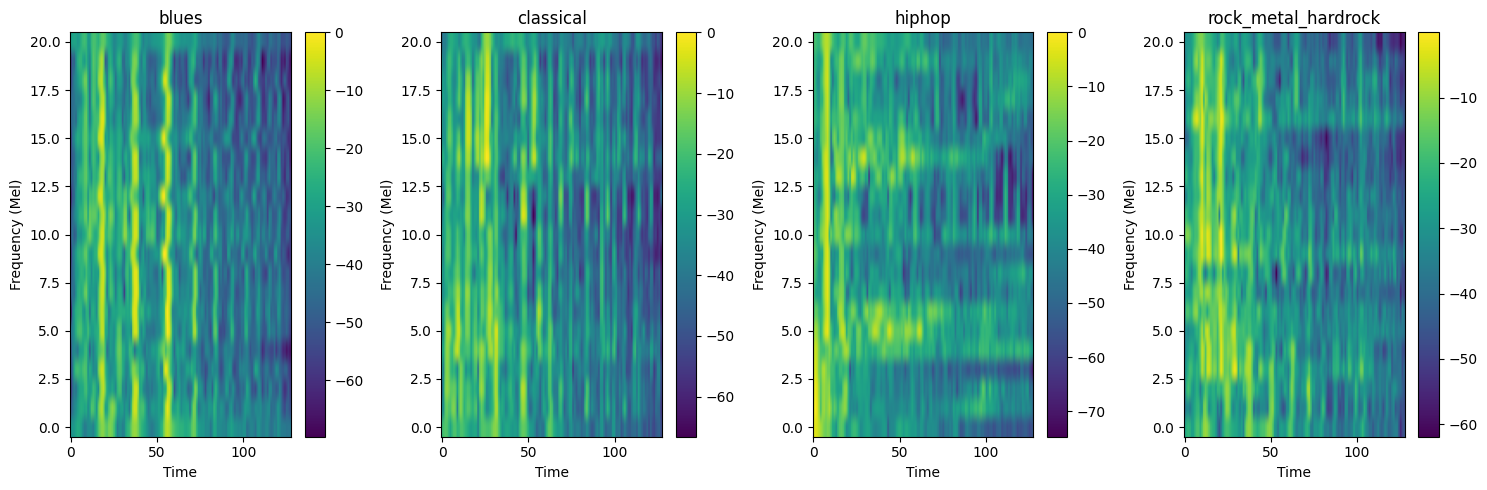

In [ ]:
# Load the MFCCs data
X_train_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/train/melgrams/X.npy')
y_train_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/train/melgrams/labels.npy')

X_val_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/val/melgrams/X.npy')
y_val_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/val/melgrams/labels.npy')

X_test_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/test/melgrams/X.npy')
y_test_melgrams = np.load('/content/drive/MyDrive/music_genre_data_di/test/melgrams/labels.npy')

# Find the unique classes and replace them with numbers
class_names = ['blues', 'classical', 'hiphop', 'rock_metal_hardrock']
label_mapping = {name: i for i, name in enumerate(class_names)}

y_train_int_melgrams = np.array([label_mapping[label] for label in y_train_melgrams])
y_val_int_melgrams = np.array([label_mapping[label] for label in y_val_melgrams])
y_test_int_melgrams = np.array([label_mapping[label] for label in y_test_melgrams])

# Convert the numpy arrays to PyTorch tensors
X_train_melgrams = np.expand_dims(X_train_melgrams, axis=1)
X_val_melgrams = np.expand_dims(X_val_melgrams, axis=1)
X_test_melgrams = np.expand_dims(X_test_melgrams, axis=1)

X_train_tensor_melgrams = torch.tensor(X_train_melgrams, dtype=torch.float32)
y_train_tensor_melgrams = torch.tensor(y_train_int_melgrams, dtype=torch.long)

X_val_tensor_melgrams = torch.tensor(X_val_melgrams, dtype=torch.float32)
y_val_tensor_melgrams = torch.tensor(y_val_int_melgrams, dtype=torch.long)

X_test_tensor_melgrams = torch.tensor(X_test_melgrams, dtype=torch.float32)
y_test_tensor_melgrams = torch.tensor(y_test_int_melgrams, dtype=torch.long)

# Create the dataloaders
batch_size = 16

train_dataset_melgrams = TensorDataset(X_train_tensor_melgrams, y_train_tensor_melgrams)
val_dataset_melgrams = TensorDataset(X_val_tensor_melgrams, y_val_tensor_melgrams)
test_dataset_melgrams = TensorDataset(X_test_tensor_melgrams, y_test_tensor_melgrams)

train_dataloader_melgrams = DataLoader(train_dataset_melgrams, batch_size=batch_size, shuffle=True)
val_dataloader_melgrams = DataLoader(val_dataset_melgrams, batch_size=batch_size, shuffle=True)
test_dataloader_melgrams = DataLoader(test_dataset_melgrams, batch_size=batch_size, shuffle=False)

# Visualize a random melgram from each class
print("\nVisualizing a random melgram from each class:")
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))
for i, class_name in enumerate(class_names):
    indices = np.where(y_train_int_melgrams == i)[0]
    random_index = np.random.choice(indices)
    spectrogram = np.squeeze(X_train_melgrams[random_index])

    ax = axes[i]
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)
    ax.set_title(class_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Mel)')
plt.tight_layout()
plt.show()

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=4):
    super(CNN, self).__init__()

    # Define the convolutional layers of the network
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
    )

    # Calculate the size of the flattened output from the convolutional layers
    with torch.no_grad():
      dummy_input = torch.zeros(1, 1, 21, 128) # (N, C, H, W)
      dummy_output = self.conv_layers(dummy_input)
      self.flattened_size = dummy_output.view(1, -1).shape[1]

    # Define the layers
    self.fc_layers = nn.Sequential(
      nn.Linear(self.flattened_size, 1024),
      nn.Linear(1024, 256),
      nn.Linear(256, 32),
      nn.Linear(32, num_classes)
    )

  # Order they are performed
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
# Define parameters for training
learning_rate = 0.001 # Changed learning_rate to 0.0001 because for 0.002 the gradients where too large and couldn't compute loss
epochs = 30

loss_function = nn.CrossEntropyLoss()

print("\n--- Step 3: CNN Training ---")

# Train CNN on CPU
print("\nTraining CNN on CPU...")
cnn_model_cpu = CNN()
optimizer_cnn_cpu = optim.SGD(cnn_model_cpu.parameters(), lr=learning_rate)
device_cpu = torch.device("cpu")

trained_cnn_model_cpu = train_model(epochs, optimizer_cnn_cpu, train_dataloader_melgrams, loss_function, cnn_model_cpu, device_cpu)

# Evaluate CNN_cpu model
print("\nEvaluating CPU CNN model on test set...")
test_loss_cnn_cpu, test_f1_cnn_cpu, test_accuracy_cnn_cpu, test_conf_matrix_cnn_cpu = evaluate_model(test_dataloader_melgrams, trained_cnn_model_cpu, loss_function, device_cpu)
print(f"CNN CPU Test Loss: {test_loss_cnn_cpu:.4f}, F1: {test_f1_cnn_cpu:.4f}, Accuracy: {test_accuracy_cnn_cpu:.4f}")

# Train CNN on GPU
print("\nTraining CNN on GPU...")
cnn_model_gpu = CNN()
optimizer_cnn_gpu = optim.SGD(cnn_model_gpu.parameters(), lr=learning_rate)

# Check if CUDA-enabled GPU is available, otherwise use CPU
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for CNN GPU training: {device_gpu}")

if device_gpu.type == 'cuda':
  trained_cnn_model_gpu = train_model(epochs, optimizer_cnn_gpu, train_dataloader_melgrams, loss_function, cnn_model_gpu, device_gpu)

  # Evaluate CNN_gpu model
  print("\nEvaluating GPU CNN model on test set...")
  test_loss_cnn_gpu, test_f1_cnn_gpu, test_accuracy_cnn_gpu, test_conf_matrix_cnn_gpu = evaluate_model(test_dataloader_melgrams, trained_cnn_model_gpu, loss_function, device_gpu)
  print(f"Loss: {test_loss_cnn_gpu:.4f}")
  print(f"F1 (macro-averaged): {test_f1_cnn_gpu:.4f}")
  print(f"Accuracy: {test_accuracy_cnn_gpu:.4f}")
  print("Confusion Matrix:\n", test_conf_matrix_cnn_gpu)
else:
  print("GPU not available")


--- Step 3: CNN Training ---

Training CNN on CPU...


KeyboardInterrupt: 

Ναι, το μοντέλο μπορεί να εκπαιδευτεί, και αυτό φαίνεται από τη σημαντική μείωση της απώλειας τόσο στην CPU όσο και στην GPU. Ωστόσο, το μοντέλο αντιμετωπίζει πρόβλημα υπερπροσαρμογής (overfitting), καθώς στο train set η τελική απώλεια είναι μικρότερη από 0.1, ενώ στο test set είναι πάνω από 2. Αυτό σημαίνει ότι το μοντέλο έχει μάθει να αναγνωρίζει πολύ καλά τα συγκεκριμένα δεδομένα εκπαίδευσης, αλλά δεν αποδίδει καλά σε άγνωστα ή τυχαία δεδομένα. Με τη χρήση GPU, η ταχύτητα εκπαίδευσης είναι περίπου 44 φορές μεγαλύτερη σε σύγκριση με την εκπαίδευση με CPU. Στο προηγούμενο ερώτημα, η διαφορά μεταξύ CPU και GPU ήταν εντελώς διαφορετική, καθώς η CPU ήταν ελαφρώς πιο γρήγορη από την GPU — περίπου κατά 1 δευτερόλεπτο. Αυτό πιθανότατα συνέβη επειδή στο πρώτο ερώτημα η μεταφορά δεδομένων από την CPU στη GPU ήταν χρονοβόρα, ενώ η ίδια η εκπαίδευση δεν απαιτούσε πολλές υπολογιστικές πράξεις. Έτσι, το πλεονέκτημα της GPU στην ταχύτητα υπολογισμών δεν μπορούσε να αντισταθμίσει τον χρόνο μεταφοράς. Αντίθετα, στο δεύτερο ερώτημα, το οποίο περιλαμβάνει πολύ περισσότερες μαθηματικές πράξεις, η GPU μπορεί να αξιοποιηθεί αποτελεσματικά και να προσφέρει σημαντικά ταχύτερη εκπαίδευση, αποδεικνύοντας την πραγματική της χρησιμότητα σε πιο απαιτητικά μοντέλα.

In [ ]:
# Implement the model using pooling and padding
class CNNWithPoolingPadding(nn.Module):
  def __init__(self, num_classes=4):
    super(CNNWithPoolingPadding, self).__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      # Layer 2
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      # Layer 3
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      # Layer 4
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2)
    )

    # Calculate the size of the flattened output from the layers
    with torch.no_grad():
      dummy_input = torch.zeros(1, 1, 21, 128)
      dummy_output = self.conv_layers(dummy_input)
      self.flattened_size = dummy_output.view(1, -1).shape[1]

    # Define the layers
    self.fc_layers = nn.Sequential(
      nn.Linear(self.flattened_size, 1024),
      nn.Linear(1024, 256),
      nn.Linear(256, 32),
      nn.Linear(32, num_classes)
    )

  # Order they are performed
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30

model_cnn_pp = CNNWithPoolingPadding()
loss_function = nn.CrossEntropyLoss()

# Check if CUDA-enabled GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  optimizer_pp = optim.SGD(model_cnn_pp.parameters(), lr=learning_rate)

  print("\n--- Train CNN using Pooling & Padding (GPU) ---")
  start_time_pp = time.time()
  trained_model_cnn_pp = train_and_validate(epochs, optimizer_pp, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_cnn_pp, device)

  end_time_pp = time.time()
  training_time_pp = end_time_pp - start_time_pp

  print("\n--- Evaluate CNN using Pooling & Padding with the Test Set ---")
  test_loss_pp, test_f1_pp, test_accuracy_pp, test_cm_pp = evaluate_model(test_dataloader_melgrams, trained_model_cnn_pp, loss_function, device)

  print(f"Loss: {test_loss_pp:.4f}")
  print(f"F1 (macro-averaged): {test_accuracy_pp:.4f}")
  print(f"Accuracy: {test_accuracy:.4f}")
  print("Confusion Matrix:\n", test_cm_pp)
else:
  print("\nΗ GPU isn't available.")


--- Train CNN using Pooling & Padding (GPU) ---
Epoch 1/30 - Train Loss: 1.3391 | Val Loss: 1.2837 | Val F1: 0.2977 | Val Accuracy: 0.4088
  --> New best validation F1: 0.2977. Model saved.
Epoch 2/30 - Train Loss: 1.2007 | Val Loss: 1.1104 | Val F1: 0.4448 | Val Accuracy: 0.5250
  --> New best validation F1: 0.4448. Model saved.
Epoch 3/30 - Train Loss: 1.0652 | Val Loss: 1.1991 | Val F1: 0.3236 | Val Accuracy: 0.4037
Epoch 4/30 - Train Loss: 0.9734 | Val Loss: 0.9659 | Val F1: 0.5328 | Val Accuracy: 0.5825
  --> New best validation F1: 0.5328. Model saved.
Epoch 5/30 - Train Loss: 0.8866 | Val Loss: 0.8425 | Val F1: 0.6386 | Val Accuracy: 0.6412
  --> New best validation F1: 0.6386. Model saved.
Epoch 6/30 - Train Loss: 0.8201 | Val Loss: 0.8660 | Val F1: 0.6123 | Val Accuracy: 0.6112
Epoch 7/30 - Train Loss: 0.7615 | Val Loss: 0.8856 | Val F1: 0.6194 | Val Accuracy: 0.6175
Epoch 8/30 - Train Loss: 0.7130 | Val Loss: 0.7512 | Val F1: 0.6985 | Val Accuracy: 0.6950
  --> New best vali

Το padding και το pooling είναι πολύ χρήσιμα στην εκπαίδευση ενός μοντέλου. Το padding είναι χρήσιμο γιατί προσθέτει δεδομένα γύρω γύρω από την είσοδο με αποτέλεσμα μετά από κάθε συνέλιξη να μην μειώνεται το μέγεθος του χάρτη με αποτέλεσμα να μην χάνονται σημαντικές πληροφορίες. Επίσης στις συνελίξεις συμμετέχουν πολύ περισσότερο τα κεντρικά δεδομένα από τα ακριανά, οπότε βάζοντας έξτρα δεδομένα στην άκρη το μοντέλο θα προσέξει περισσότερο τα αρχικά ακριανά δεδομένα και επειδή δεν συμμετέχουν τα ακριανά δεδομένα τόσο πολύ στις συνελίξεις το γεγονός ότι είναι έξτρα δεδομένα δεν επιρρεάζει τόσο πολύ το αποτέλεσμα. Το pooling κρατάει μόνο τα πιο έντονα χαρακτηριστικά μίας μικρή περιοχής με αποτέλεσμα να είναι πιο μικρός ο αριθμός των υπολογισμών στα επόμενα επίπεδα και το μοντέλο εστιάζει μόνο στα καθοριστικά δεδομένα.

Παρατηρούμε ότι ο χρόνος μειώνεται σημαντικά και αυτό οφείλεται στο pooling που μειώνει τις διαστάσεις για τα επόμενα επίπεδα με αποτέλεσμα να έχουν λιγότερες πράξεις να πραγματοποιήσουν.

In [ ]:
# Implement the model using the relu function as an activation function
class FinalCNN(nn.Module):
  def __init__(self, num_classes=4):
    super(FinalCNN, self).__init__()
    self.conv_layers = nn.Sequential(
      # 1st layer
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      # 2nd layer
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      # 3rd layer
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      # 4th layer
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    # Calculate the size of the flattened output from the convolutional layers
    with torch.no_grad():
      dummy_input = torch.zeros(1, 1, 21, 128)
      dummy_output = self.conv_layers(dummy_input)
      self.flattened_size = dummy_output.view(1, -1).shape[1]

    # Define the layers
    self.fc_layers = nn.Sequential(
      nn.Linear(self.flattened_size, 1024),
      nn.ReLU(),
      nn.Linear(1024, 256),
      nn.ReLU(),
      nn.Linear(256, 32),
      nn.ReLU(),
      nn.Linear(32, num_classes)
    )

  # Order they are performed
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30

model_final_cnn = FinalCNN()
loss_function = nn.CrossEntropyLoss()

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  optimizer_final = optim.SGD(model_final_cnn.parameters(), lr=learning_rate)

  print("\n--- Train Final CNN (using ReLU) ---")
  trained_model_final = train_and_validate(epochs, optimizer_final, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_final_cnn, device)

  print("\n--- Evaluate Final CNN with the Test Set ---")
  test_loss_final, test_f1_final, test_accuracy_final, test_cm_final = evaluate_model(test_dataloader_melgrams, trained_model_final, loss_function, device)

  print(f"Loss: {test_loss_final:.4f}")
  print(f"F1 (macro-averaged): {test_f1_final:.4f}")
  print(f"Accuracy: {test_accuracy_final:.4f}")
  print("Confusion Matrix:\n", test_cm_final)
else:
  print("\nGPU isn't available.")


--- Train Final CNN (using ReLU) ---
Epoch 1/30 - Train Loss: 1.3822 | Val Loss: 1.3718 | Val F1: 0.2419 | Val Accuracy: 0.3638
  --> New best validation F1: 0.2419. Model saved.
Epoch 2/30 - Train Loss: 1.3654 | Val Loss: 1.3552 | Val F1: 0.1808 | Val Accuracy: 0.2812
Epoch 3/30 - Train Loss: 1.3282 | Val Loss: 1.2792 | Val F1: 0.3857 | Val Accuracy: 0.4637
  --> New best validation F1: 0.3857. Model saved.
Epoch 4/30 - Train Loss: 1.2588 | Val Loss: 1.2417 | Val F1: 0.3059 | Val Accuracy: 0.3837
Epoch 5/30 - Train Loss: 1.1937 | Val Loss: 1.1348 | Val F1: 0.3737 | Val Accuracy: 0.4437
Epoch 6/30 - Train Loss: 1.1313 | Val Loss: 1.1018 | Val F1: 0.3845 | Val Accuracy: 0.4487
Epoch 7/30 - Train Loss: 1.0881 | Val Loss: 1.0783 | Val F1: 0.5515 | Val Accuracy: 0.5463
  --> New best validation F1: 0.5515. Model saved.
Epoch 8/30 - Train Loss: 1.0634 | Val Loss: 1.1159 | Val F1: 0.5052 | Val Accuracy: 0.5325
Epoch 9/30 - Train Loss: 1.0352 | Val Loss: 1.0904 | Val F1: 0.5003 | Val Accurac

Παρατηρούμαι μία πολύ σημαντική αύξηση στην ακρίβεια του μοντέλου με την χρήση της relu σε σύγκριση με τα υπόλοιπα μοντέλα. Αυτό γίνεται γιατί η relu δίνει την δυνατότητα στο μοντέλο να κάνει πιο σύνθετες συναρτήσεις για τα χαρακτηριστικά των δεδομένων της εισόδου.

In [ ]:
# Sets the seed for various random number generators to ensure reproducibility of experiments
def set_seed(seed_value=42):
  # Set seed for Python's built-in random module
  random.seed(seed_value)

  # Set seed for PyTorch's CPU random number generator
  torch.manual_seed(seed_value)

  if torch.cuda.is_available():
    # Set seed for PyTorch's GPU random number generator
    torch.cuda.manual_seed(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30
loss_function = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("--- Fisrt execution to test seed works as intended ---")
# Define seed
set_seed(42)
model1 = FinalCNN()
optimizer_run1 = optim.SGD(model1.parameters(), lr=learning_rate)
if torch.cuda.is_available():
  trained_model1 = train_and_validate(epochs, optimizer_run1, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model1, device)
  test_loss1, test_acc1, test_f1_1, _ = evaluate_model(test_dataloader_melgrams, trained_model1, loss_function, device)
  print(f"\n1st execution results -> Accuracy: {test_acc1:.6f}, F1: {test_f1_1:.6f}")
else:
  print("GPU isn't available")

print("\n--- Second execution to test seed works as intended ---")
# Define seed
set_seed(42)
model2 = FinalCNN()
optimizer_run2 = optim.SGD(model2.parameters(), lr=0.002)
if torch.cuda.is_available():
  trained_model2 = train_and_validate(epochs, optimizer_run2, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model2, device)
  test_loss2, test_acc2, test_f1_2, _ = evaluate_model(test_dataloader_melgrams, trained_model2, loss_function, device)
  print(f"\n2nd execution results -> Accuracy: {test_acc1:.6f}, F1-Score: {test_f1_1:.6f}")
else:
  print("GPU isn't available")

# Check if the results are the same
if device.type == 'cuda' and test_acc1 == test_acc2 and test_f1_1 == test_f1_2:
  print("\nSeed works as intended")
else:
  print("\nResults aren't identical! Meaning seed failed")

--- Fisrt execution to test seed works as intended ---
Epoch 1/30 - Train Loss: 1.3789 | Val Loss: 1.3654 | Val F1: 0.2681 | Val Accuracy: 0.3538
  --> New best validation F1: 0.2681. Model saved.
Epoch 2/30 - Train Loss: 1.3353 | Val Loss: 1.3045 | Val F1: 0.2513 | Val Accuracy: 0.3550
Epoch 3/30 - Train Loss: 1.2552 | Val Loss: 1.2382 | Val F1: 0.3238 | Val Accuracy: 0.4037
  --> New best validation F1: 0.3238. Model saved.
Epoch 4/30 - Train Loss: 1.2067 | Val Loss: 1.1996 | Val F1: 0.2695 | Val Accuracy: 0.3937
Epoch 5/30 - Train Loss: 1.1522 | Val Loss: 1.1324 | Val F1: 0.3228 | Val Accuracy: 0.4375
Epoch 6/30 - Train Loss: 1.1059 | Val Loss: 1.1192 | Val F1: 0.4739 | Val Accuracy: 0.4800
  --> New best validation F1: 0.4739. Model saved.
Epoch 7/30 - Train Loss: 1.0707 | Val Loss: 1.0752 | Val F1: 0.4376 | Val Accuracy: 0.4738
Epoch 8/30 - Train Loss: 1.0527 | Val Loss: 1.0475 | Val F1: 0.4737 | Val Accuracy: 0.5025
Epoch 9/30 - Train Loss: 1.0313 | Val Loss: 1.0694 | Val F1: 0.4

In [ ]:
# Create a list with the optimizers we'll use
optimizers_to_test = {
  "SGD": optim.SGD,
  "Adam": optim.Adam,
  "RMSprop": optim.RMSprop,
  "Adagrad": optim.Adagrad,
  "RAdam": optim.RAdam,
  "Adamax": optim.Adamax,
  "NAdam": optim.NAdam,
  "Adadelta": optim.Adadelta,
  "ASGD": optim.ASGD
}

results = []

if torch.cuda.is_available():
  # Iterate through all the optimizers
  for name, opt in optimizers_to_test.items():
    print(f"\n--- Train Using Optimizer: {name} ---")

    # Ensure same conditions for all optimizers for better comparison
    set_seed(42)

    # Define model
    model = FinalCNN()

    # Must move the model to the correct device before the initialization of the optimizers
    model.to(device)

    if name == "Adam":
      optimizer = opt(model.parameters(), lr=0.001) # Adam often works better with a slightly different lr
    else:
      optimizer = opt(model.parameters(), lr=0.002)

    loss_function = nn.CrossEntropyLoss()

    start_time = time.time()

    # Train model
    trained_model = train_and_validate(epochs, optimizer, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model, device)

    end_time = time.time()
    training_time = end_time - start_time

    _, f1, accuracy, _ = evaluate_model(test_dataloader_melgrams, trained_model, loss_function, device)

    results.append({
      "Optimizer": name,
      "F1-Score": f1,
      "Accuracy": accuracy,
      "Training Time (s)": round(training_time, 2)
    })
    print(f"Results for optimizer {name}: Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={training_time:.2f}s")

  # Plot a graph to visualise the results
  results_df = pd.DataFrame(results)
  print("\n--- Comparative Table of Optimizer Performance ---")
  print(results_df.to_string(index=False))
else:
  print("GPU isn't available")


--- Train Using Optimizer: SGD ---
Epoch 1/30 - Train Loss: 1.3789 | Val Loss: 1.3654 | Val F1: 0.2681 | Val Accuracy: 0.3538
  --> New best validation F1: 0.2681. Model saved.
Epoch 2/30 - Train Loss: 1.3353 | Val Loss: 1.3045 | Val F1: 0.2513 | Val Accuracy: 0.3550
Epoch 3/30 - Train Loss: 1.2552 | Val Loss: 1.2382 | Val F1: 0.3238 | Val Accuracy: 0.4037
  --> New best validation F1: 0.3238. Model saved.
Epoch 4/30 - Train Loss: 1.2067 | Val Loss: 1.1996 | Val F1: 0.2695 | Val Accuracy: 0.3937
Epoch 5/30 - Train Loss: 1.1522 | Val Loss: 1.1324 | Val F1: 0.3228 | Val Accuracy: 0.4375
Epoch 6/30 - Train Loss: 1.1059 | Val Loss: 1.1192 | Val F1: 0.4739 | Val Accuracy: 0.4800
  --> New best validation F1: 0.4739. Model saved.
Epoch 7/30 - Train Loss: 1.0707 | Val Loss: 1.0752 | Val F1: 0.4376 | Val Accuracy: 0.4738
Epoch 8/30 - Train Loss: 1.0527 | Val Loss: 1.0475 | Val F1: 0.4737 | Val Accuracy: 0.5025
Epoch 9/30 - Train Loss: 1.0313 | Val Loss: 1.0694 | Val F1: 0.4663 | Val Accuracy:

In [ ]:

class CNNWithBatchNorm(nn.Module):
  def __init__(self, num_classes=4):
    super(CNNWithBatchNorm, self).__init__()
    self.conv_layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(1, 16, 5, padding=2),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2),
      # Layer 2
      nn.Conv2d(16, 32, 5, padding=2),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2),
      # Layer 3
      nn.Conv2d(32, 64, 5, padding=2),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2),
      # Layer 4
      nn.Conv2d(64, 128, 5, padding=2),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    # Calculate the size of the flattened output from the convolutional layers
    with torch.no_grad():
      dummy_input = torch.zeros(1, 1, 21, 128)
      dummy_output = self.conv_layers(dummy_input)
      self.flattened_size = dummy_output.view(1, -1).shape[1]

    # Define the layers
    self.fc_layers = nn.Sequential(
      nn.Linear(self.flattened_size, 1024),
      nn.ReLU(),
      nn.Linear(1024, 256),
      nn.ReLU(),
      nn.Linear(256, 32),
      nn.ReLU(),
      nn.Linear(32, num_classes)
    )

  # Order they are performed
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 30

model_bn = CNNWithBatchNorm()
loss_function = nn.CrossEntropyLoss()

# Check if CUDA-enabled GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  set_seed(42)
  optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)

  trained_model_bn = train_and_validate(epochs, optimizer_bn, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_bn, device)

  loss_bn, f1_bn, accuracy_bn, cm_bn = evaluate_model(test_dataloader_melgrams, trained_model_bn, loss_function, device)

  print(f"Loss: {loss_bn:.4f}")
  print(f"F1 (macro-averaged): {f1_bn:.4f}")
  print(f"Accuracy: {accuracy_bn:.4f}")
  print("Confusion Matrix:\n", cm_bn)
else:
  print("\nGPU isn't available.")

Epoch 1/30 - Train Loss: 0.9153 | Val Loss: 0.7696 | Val F1: 0.6700 | Val Accuracy: 0.6825
  --> New best validation F1: 0.6700. Model saved.
Epoch 2/30 - Train Loss: 0.6911 | Val Loss: 0.6039 | Val F1: 0.7506 | Val Accuracy: 0.7575
  --> New best validation F1: 0.7506. Model saved.
Epoch 3/30 - Train Loss: 0.6004 | Val Loss: 0.7711 | Val F1: 0.6444 | Val Accuracy: 0.6687
Epoch 4/30 - Train Loss: 0.5495 | Val Loss: 0.7154 | Val F1: 0.6826 | Val Accuracy: 0.7037
Epoch 5/30 - Train Loss: 0.5132 | Val Loss: 0.9756 | Val F1: 0.6446 | Val Accuracy: 0.6587
Epoch 6/30 - Train Loss: 0.4595 | Val Loss: 0.7981 | Val F1: 0.6984 | Val Accuracy: 0.7087
Epoch 7/30 - Train Loss: 0.3953 | Val Loss: 1.3550 | Val F1: 0.5512 | Val Accuracy: 0.5763
Epoch 8/30 - Train Loss: 0.3624 | Val Loss: 0.9485 | Val F1: 0.6440 | Val Accuracy: 0.6863
Epoch 9/30 - Train Loss: 0.3343 | Val Loss: 1.2966 | Val F1: 0.5810 | Val Accuracy: 0.5988
Epoch 10/30 - Train Loss: 0.2692 | Val Loss: 0.7772 | Val F1: 0.7442 | Val Accu

In [ ]:
class CNNWithRegularization(nn.Module):
  def __init__(self, num_classes=4, dropout_rate=0.5):
    super(CNNWithRegularization, self).__init__()
    # We use the BatchNorm as it is already strong
    self.conv_layers = CNNWithBatchNorm().conv_layers
    self.flattened_size = CNNWithBatchNorm().flattened_size

    # Addidng dropout to the layers
    self.fc_layers = nn.Sequential(
      nn.Linear(self.flattened_size, 1024),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.Linear(1024, 256),
      nn.ReLU(),
      nn.Dropout(p=dropout_rate),
      nn.Linear(256, 32),
      nn.ReLU(),
      nn.Linear(32, num_classes)
    )

  # Order they are performed
  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [ ]:
# Define parameters for training
learning_rate = 0.002
epochs = 60

model_reg1 = CNNWithBatchNorm()
model_reg2 = CNNWithRegularization()
model_reg3 = CNNWithRegularization()

loss_function = nn.CrossEntropyLoss()

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  set_seed(42)

  # Move models to the correct device BEFORE initializing optimizers
  model_reg1.to(device)
  model_reg2.to(device)
  model_reg3.to(device)

  # Initialize optimizers AFTER the models are on the correct device
  # Adding a weight decay to the optimizer
  optimizer_reg1 = optim.Adagrad(model_reg1.parameters(), lr=0.002, weight_decay=1e-4)
  optimizer_reg2 = optim.Adagrad(model_reg2.parameters(), lr=0.002)
  optimizer_reg3 = optim.Adagrad(model_reg3.parameters(), lr=0.002, weight_decay=1e-4)


  # Fisrt execution with the weight decay
  print("\n--- Execution using weight decay ---\n")
  # Pass the model that is already on the correct device
  trained_model_reg1 = train_and_validate(epochs, optimizer_reg1, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_reg1, device)
  loss_reg1, f1_reg1, accuracy_reg1, cm_reg1 = evaluate_model(test_dataloader_melgrams, trained_model_reg1, loss_function, device)
  print(f"Loss: {loss_reg1:.4f}")
  print(f"F1 (macro-averaged): {f1_reg1:.4f}")
  print(f"Accuracy: {accuracy_reg1:.4f}")
  print("Confusion Matrix:\n", cm_reg1)

  print("\n--- Execution using regularization ---\n")
  # Pass the model that is already on the correct device
  trained_model_reg2 = train_and_validate(epochs, optimizer_reg2, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_reg2, device)
  loss_reg2, f1_reg2, accuracy_reg2, cm_reg2 = evaluate_model(test_dataloader_melgrams, trained_model_reg2, loss_function, device)
  print(f"Loss: {loss_reg2:.4f}")
  print(f"F1 (macro-averaged): {f1_reg2:.4f}")
  print(f"Accuracy: {accuracy_reg2:.4f}")
  print("Confusion Matrix:\n", cm_reg2)

  print("\n--- Execution using weight decay ---\n")
  # Pass the model that is already on the correct device
  trained_model_reg3 = train_and_validate(epochs, optimizer_reg3, train_dataloader_melgrams, val_dataloader_melgrams, loss_function, model_reg3, device)
  loss_reg3, f1_reg3, accuracy_reg3, cm_reg3 = evaluate_model(test_dataloader_melgrams, trained_model_reg3, loss_function, device)
  print(f"Loss: {loss_reg3:.4f}")
  print(f"F1 (macro-averaged): {f1_reg3:.4f}")
  print(f"Accuracy: {accuracy_reg3:.4f}")
  print("Confusion Matrix:\n", cm_reg3)

else:
  print("\nGPU isn't available.")

--- Execution using weight decay ---

Epoch 1/60 - Train Loss: 0.8789 | Val Loss: 0.6314 | Val F1: 0.7349 | Val Accuracy: 0.7438
  --> New best validation F1: 0.7349. Model saved.
Epoch 2/60 - Train Loss: 0.6114 | Val Loss: 0.8068 | Val F1: 0.6613 | Val Accuracy: 0.6700
Epoch 3/60 - Train Loss: 0.5280 | Val Loss: 0.5720 | Val F1: 0.7564 | Val Accuracy: 0.7675
  --> New best validation F1: 0.7564. Model saved.
Epoch 4/60 - Train Loss: 0.4751 | Val Loss: 0.5380 | Val F1: 0.7960 | Val Accuracy: 0.7987
  --> New best validation F1: 0.7960. Model saved.
Epoch 5/60 - Train Loss: 0.4295 | Val Loss: 0.5536 | Val F1: 0.7816 | Val Accuracy: 0.7900
Epoch 6/60 - Train Loss: 0.3857 | Val Loss: 0.5193 | Val F1: 0.8012 | Val Accuracy: 0.8000
  --> New best validation F1: 0.8012. Model saved.
Epoch 7/60 - Train Loss: 0.3315 | Val Loss: 0.5308 | Val F1: 0.7890 | Val Accuracy: 0.7900
Epoch 8/60 - Train Loss: 0.2939 | Val Loss: 0.6409 | Val F1: 0.7623 | Val Accuracy: 0.7662
Epoch 9/60 - Train Loss: 0.253

Παρατηρούμε ότι μεγαλύτερο ρόλο παίζει το regularization από τα weight decays καθώς όταν είναι μόνα τους υπάρχει μια πιο μικρή αύξηση στην ακρίβεια από ότι με το regularization και σχεδόν καμία όταν προσθέτουμε τα weight decays στο optimizer. Ωστόσο σε σύγκριση με το απλό DNN από το ερώτημα 2 υπάρχει μεγάλη βελτίωση κατά περίπου 25%. Και σε συγκριση με το BatchNOrms έχουμε αύξηση περίπου 2%.

In [ ]:
# Predicts the song style for every second
def inference(model, data_loader, device='cpu'):
  model.to(device)

  # Disables the dropout
  model.eval()

  predictions = []

  # Doesn't calculate gradients because we don't train it so we don't need it. We save time
  with torch.no_grad():
    for inputs, _ in data_loader:
      inputs = inputs.to(device)

      # Give the song to the model and gives back the labels
      outputs = model(inputs)

      # We only keep the hightest label
      _, predicted = torch.max(outputs.data, 1)
      predictions.extend(predicted.cpu().numpy())

  return predictions

In [ ]:
# We get the code from the file we were given untouched!

# Step 1: Install the necessary libraries
!pip install yt-dlp pydub

import yt_dlp
from pydub import AudioSegment
import os

def download_youtube(youtube_url, output_path="output.wav"):
    try:
        # Download audio using yt_dlp
        ydl_opts = {
            'format': 'bestaudio/best',
            'outtmpl': 'downloaded_audio.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }],
        }

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([youtube_url])

        audio_file = "downloaded_audio.mp3"
        audio = AudioSegment.from_file(audio_file)
        audio.export(output_path, format="wav")

        os.remove(audio_file)

    except Exception as e:
        print(f"Download failed: {e}")
        raise

import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21

def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("output.wav")
    np.save("50_melgrams.npy", melgrams)

youtube_to_melgram('https://www.youtube.com/watch?v=5qm8PH4xAss')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.2 MB/s eta 0:00:00
[youtube] Extracting URL: https://www.youtube.com/watch?v=5qm8PH4xAss
[youtube] 5qm8PH4xAss: Downloading webpage
[youtube] 5qm8PH4xAss: Downloading tv client config
[youtube] 5qm8PH4xAss: Downloading player 612f74a3-main
[youtube] 5qm8PH4xAss: Downloading tv player API JSON
[youtube] 5qm8PH4xAss: Downloading ios player API JSON
[youtube] 5qm8PH4xAss: Downloading m3u8 information
[info] 5qm8PH4xAss: Downloading 1 format(s): 251
[download] Destination: downloaded_audio.webm
[download] 100% of    3.80MiB in 00:00:00 at 46.61MiB/s  
[ExtractAudio] Destination: downloaded_audio.mp3
Deleting original file downloaded_audio.webm (pass -k to keep)


Ανάλυση αρχείου: 50_melgrams.npy
Το αρχείο φορτώθηκε με επιτυχία. Βρέθηκαν 248 δευτερόλεπτα (δείγματα).
Προστέθηκε η διάσταση καναλιού. Νέο shape: (248, 1, 21, 128)
Το μοντέλο επεξεργάζεται το τραγούδι...
Η επεξεργασία ολοκληρώθηκε.


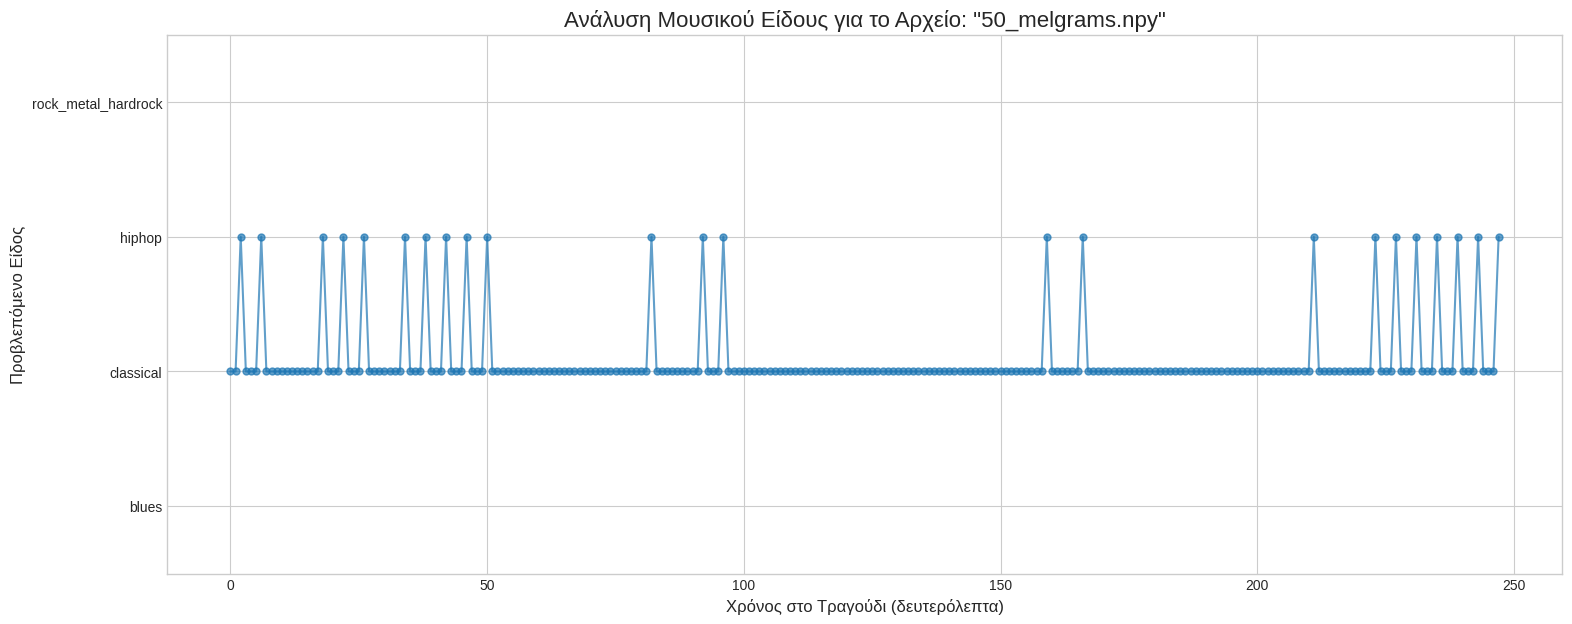

In [ ]:
filename = '50_melgrams.npy'

# Load the mel-spectrograms from the .npy file
melgrams = np.load(filename)

# Check if any dimension is absent
if melgrams.ndim == 3:
  melgrams = np.expand_dims(melgrams, axis=1)

# Convertion to PyTorch Tensor
melgrams_tensor = torch.tensor(melgrams, dtype=torch.float32)

# Creation of Dataset and DataLoader.
dummy_labels = torch.zeros(len(melgrams_tensor))

dataset = TensorDataset(melgrams_tensor, dummy_labels)

data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

predictions = inference(trained_model_reg3, data_loader, device=device)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 7))

timestamps = np.arange(len(predictions))

y_ticks_locations = list(label_mapping.values())
y_tick_labels = list(label_mapping.keys())

ax.plot(timestamps, predictions, marker='o', linestyle='-', markersize=5, alpha=0.7, label='Prediction Model')

ax.set_title(f'Analysis of music file: "{filename}"', fontsize=16)
ax.set_xlabel("Seconds of the song", fontsize=12)
ax.set_ylabel("Predicted Genre", fontsize=12)

ax.set_yticks(y_ticks_locations)

ax.set_yticklabels(y_tick_labels, fontsize=10)



ax.set_ylim(-0.5, len(y_tick_labels) - 0.5)

plt.show()